# Rectify
Does using "normalized" mean state improve RO's ability to simulate mean state? Based on this reference:  
Huang, P., Chen, Y., Li, J. & Yan, H. "Redefined background state in the tropical Pacific resolves the entanglement between the background state and ENSO". *npj Clim Atmos Sci* 7, 147 (2024).

## Imports

In [1]:
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import pandas as pd
import os
import scipy.stats
import copy

# Import custom modules
from src.XRO import XRO, xcorr
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def plot_pdf(ax, x, edges, **plot_kwargs):
    """Plot empirical PDF on given ax for specified data (x),
    using specified edges for histogram"""

    ## compute pdf, skewness, and gaussian best fit
    pdf, _ = src.utils.get_empirical_pdf(x, edges=edges)
    skew = scipy.stats.skew(x)
    pdf_gauss, pdf_gauss_pts = src.utils.get_gaussian_best_fit(x)

    ## plot pdf
    ax.stairs(pdf, edges, lw=1.5, label=f"skew = {skew:.2f}", **plot_kwargs)

    ## plot gaussian best fit
    ax.plot(pdf_gauss_pts, pdf_gauss, c="k", lw=1)

    ## label and hide yticks
    ax.legend(prop=dict(size=8))
    ax.set_yticks([])

    return ax


def label_ac_ax(ax):
    """add labels to growth rate annual cycle plot (ax object)"""

    ax.set_ylabel(r"Growth rate (yr$^{-1}$)")
    ax.axhline(0, c="k", ls="-", lw=0.5)
    ax.set_xticks([1, 8, 12], labels=["Jan", "Aug", "Dec"])

    return

## Load data

In [3]:
## ORAS5 reanalysis (use as benchmark)
oras_load_fp = pathlib.Path(DATA_FP, "XRO_indices_oras5.nc")
Th_oras = xr.open_dataset(oras_load_fp)

## rename variables for consistency and trim so time periods covered are the same
Th_oras = Th_oras[["Nino34", "WWV"]].rename({"Nino34": "T", "WWV": "h"})

## non-dimensionalize
normalize = lambda x: x / x.std()
for n in ["T", "h"]:
    Th_oras[f"{n}_norm"] = normalize(Th_oras[n])

## PDFs

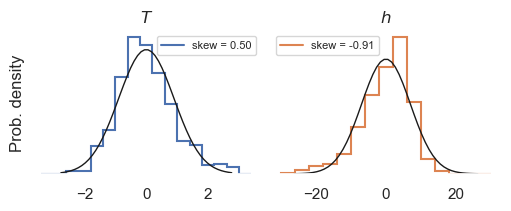

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2), layout="constrained")

## plot data
colors = sns.color_palette()[:2]
ax0 = plot_pdf(
    axs[0], Th_oras["T"].values, edges=np.arange(-3.4, 3.8, 0.4), color=colors[0]
)
ax1 = plot_pdf(
    axs[1], Th_oras["h"].values, edges=np.arange(-30, 32, 4), color=colors[1]
)

## label
ax0.set_title(r"$T$")
ax1.set_title(r"$h$")
ax0.set_ylabel("Prob. density")
plt.show()

## Fit RO model

In [5]:
## specify order of annual cycle
ac_order = 3

## specify which parameters to mask annual cycle out for [(y_idx0, x_idx0), ...]
ac_mask_idx = [(1, 1)]

# ## pull out variables for convenience
# T = copy.deepcopy(Th_oras["T_norm"])
# h = copy.deepclpy

## initialize model
model = XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## get fit for reanalysis
fit = model.fit_matrix(Th_oras[["T_norm", "h_norm"]], ac_mask_idx=ac_mask_idx)

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


## Plot RO parameters

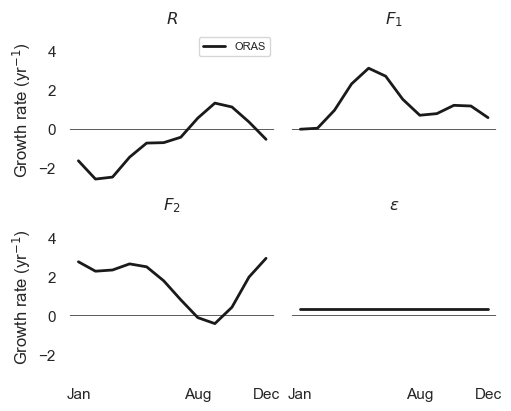

In [6]:
## Get parameters for ORAS and MPI
params = model.get_RO_parameters(fit).rename({"cycle": "month"})

## get labels of parameters for plotting
labels = [r"$R$", r"$F_1$", r"$F_2$", r"$\epsilon$"]
var_names = ["R", "F1", "F2", "epsilon"]

## set up plot
fig, axs = plt.subplots(2, 2, figsize=(5, 4), layout="constrained")

## separate plo for each set of parameters
for i, (ax, label, n) in enumerate(zip(axs.flatten(), labels, var_names)):

    ### plot seasonal cycle parameter for each
    plot_kwargs = dict(c="k", ls="-", lw=2, label="ORAS")
    ax.plot(params.month, params[n], **plot_kwargs)
    ax.set_title(label)
    ax.set_ylim([-3, 5])
    label_ac_ax(ax)

## make plot less clustered
for ax in axs[0, :]:
    ax.set_xlabel(None)
    ax.set_xticks([])
for ax in axs[:, 1]:
    ax.set_ylabel(None)
    ax.set_yticks([])
for ax in axs[:, 0]:
    ax.set_yticks([-2, 0, 2, 4])

axs[0, 0].legend(prop=dict(size=8))
plt.show()

## Look at residuals

### Compute actual/predicted time derivative

In [7]:
## compute time derivatives for T and h
Th_np = src.XRO._convert_to_numpy(Th_oras[["T_norm", "h_norm"]])
dx_dt = src.XRO.gradient(Th_np)

## add to dataset
Th_oras = Th_oras.assign(dict(dT_dt=("time", dx_dt[0]), dh_dt=("time", dx_dt[1])))

## compute terms in RO
T = copy.deepcopy(Th_oras["T_norm"])
h = copy.deepcopy(Th_oras["h_norm"])

RT = params["R"] * T.groupby("time.month")
F1h = params["F1"] * h.groupby("time.month")
F2T = params["F2"] * T.groupby("time.month")
eh = params["epsilon"] * T.groupby("time.month")

# put in xarray
Th_oras = Th_oras.assign(
    dict(
        RT=("time", RT.data),
        F1h=("time", F1h.data),
        F2T=("time", F2T.data),
        eh=("time", eh.data),
    )
)

### Compute and plot residuals

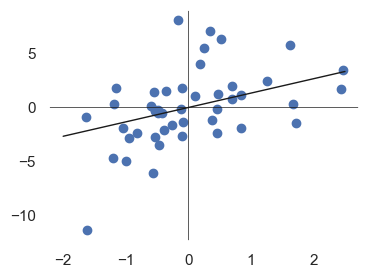

In [12]:
## compute residual
dTdt_res = Th_oras["dT_dt"] - Th_oras["F1h"]

## specify month for plotting
m = 9

## function to select month
selmon = lambda x, m: x.sel(time=(x.time.dt.month == m))

## set up plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot data
ax.scatter(selmon(Th_oras["T_norm"], m=m), selmon(dTdt_res, m=m))

## plot best fit line
T_test = np.linspace(-2, 2.5)
ax.plot(T_test, params["R"].sel(month=m).values.item() * T_test, c="k", lw=1)

## label
ax.axvline(0, c="k", lw=0.5)
ax.axhline(0, c="k", lw=0.5)

plt.show()